# Training word embeddings

This tutorial refers to https://gluon-nlp.mxnet.io/examples/word_embedding/word_embedding_training.html#Training-word-embeddings

gluonnlp also provides everything needed to train your own embeddings<br>
Datasets as well as model definitions are included.

In [24]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import time
import math
import logging
import random

import mxnet as mx
import gluonnlp as nlp
import numpy as np
from scipy import stats

context = mx.cpu()  # Enable this to run on CPU
#context = mx.gpu(0)  # Enable this to run on GPU

## Loading the training data

We first load the Text8 corpus from the Large Text Compression Benchmark which includes the first 100 MB of cleaned text from the English Wikipedia.<br>
We follow the common practice of splitting every 10‘000 tokens to obtain “sentences” for embedding training.

In [2]:
dataset = nlp.data.Text8(segment='train')

reference of Text8 http://mattmahoney.net/dc/textdata.html

In [3]:
print('# sentences:', len(dataset))
for sentence in dataset[:3]:
    print('# tokens:', len(sentence), sentence[:6])

# sentences: 1701
# tokens: 10000 ['anarchism', 'originated', 'as', 'a', 'term', 'of']
# tokens: 10000 ['reciprocity', 'qualitative', 'impairments', 'in', 'communication', 'as']
# tokens: 10000 ['with', 'the', 'aegis', 'of', 'zeus', 'when']


We then build a vocabulary of all the tokens in the dataset that occur more than 5 times and replace the words with their indices.

In [4]:
itertools.chain.from_iterable(dataset)

In [5]:
counter = nlp.data.count_tokens(itertools.chain.from_iterable(dataset))

In [6]:
counter

Counter({'anarchism': 303,
         'originated': 572,
         'as': 131815,
         'a': 325873,
         'term': 7219,
         'of': 593677,
         'abuse': 563,
         'first': 28810,
         'used': 22737,
         'against': 8432,
         'early': 10172,
         'working': 2271,
         'class': 3412,
         'radicals': 116,
         'including': 9633,
         'the': 1061396,
         'diggers': 25,
         'english': 11868,
         'revolution': 2029,
         'and': 416629,
         'sans': 68,
         'culottes': 6,
         'french': 8736,
         'whilst': 481,
         'is': 183153,
         'still': 7378,
         'in': 372201,
         'pejorative': 114,
         'way': 6433,
         'to': 316376,
         'describe': 1352,
         'any': 11803,
         'act': 3502,
         'that': 109510,
         'violent': 653,
         'means': 4165,
         'destroy': 466,
         'organization': 2374,
         'society': 4067,
         'it': 73334,
         'h

In [7]:
vocab = nlp.Vocab(
    counter,
    unknown_token=None,
    padding_token=None,
    bos_token=None,
    eos_token=None,
    min_freq=5)

In [8]:
vocab

Vocab(size=71290, unk="None", reserved="None")

In [9]:
dataset[1]

['reciprocity',
 'qualitative',
 'impairments',
 'in',
 'communication',
 'as',
 'manifested',
 'by',
 'at',
 'least',
 'one',
 'of',
 'the',
 'following',
 'delay',
 'in',
 'or',
 'total',
 'lack',
 'of',
 'the',
 'development',
 'of',
 'spoken',
 'language',
 'not',
 'accompanied',
 'by',
 'an',
 'attempt',
 'to',
 'compensate',
 'through',
 'alternative',
 'modes',
 'of',
 'communication',
 'such',
 'as',
 'gesture',
 'or',
 'mime',
 'in',
 'individuals',
 'with',
 'adequate',
 'speech',
 'marked',
 'impairment',
 'in',
 'the',
 'ability',
 'to',
 'initiate',
 'or',
 'sustain',
 'a',
 'conversation',
 'with',
 'others',
 'stereotyped',
 'and',
 'repetitive',
 'use',
 'of',
 'language',
 'or',
 'idiosyncratic',
 'language',
 'lack',
 'of',
 'varied',
 'spontaneous',
 'make',
 'believe',
 'play',
 'or',
 'social',
 'imitative',
 'play',
 'appropriate',
 'to',
 'developmental',
 'level',
 'restricted',
 'repetitive',
 'and',
 'stereotyped',
 'patterns',
 'of',
 'behavior',
 'interests'

In [10]:
def code(s):
    return [vocab[t] for t in s if t in vocab]

coded_dataset = dataset.transform(code, lazy=False)

In [11]:
print(len(dataset[0]))
print(len(coded_dataset[0]))

10000
9895


In [13]:
def code_(s):
    return [t for t in s if t not in vocab]

coded_dataset_ = dataset.transform(code_, lazy=False)

In [14]:
print(len(coded_dataset_[0]))

105


min_freq=5

In [15]:
for notin in coded_dataset_[0]:
    print(notin)

lahontan
septentrionale
anarchiste
mutuellisme
amoralism
individualistically
experimenal
yarros
signficiant
mutualists
figureheads
jacque
libertaire
comunismo
libertario
dynamost
nechaev
bourses
travails
pataud
pouget
socities
syndical
workerist
makhnovshchina
dielo
truda
platformist
collectivised
fabbri
reponse
antifa
religiousity
obediance
stabalised
starhawk
ricourt
mysogyny
primitivists
voltairine
competiting
contractarianism
narveson
raico
ecofeminism
primitivists
formet
shuns
crimethinc
mcquinn
infoshop
postanarchism
autonomism
situationism
zapatismo
postanarchism
wolfi
landstreicher
graeber
grubacic
komboa
mbah
infoshops
cypherpunk
parliamentarianism
condoning
voluntaryism
peacott
panarchists
criticsed
reactionists
unfeasible
landauer
lumpenproletariat
spoilt
dilettantes
situationists
eurocentric
proffessed
totalitarians
litist
alfredsson
rossell
makhnovschina
yarros
anarchoblogs
infoshop
neurodevelopmental
asd
stimulations
cuddling
cuddling
bonobos
oversensitivity
underreactivi

Source code for mxnet.gluon.data.dataset <br>
https://mxnet.incubator.apache.org/_modules/mxnet/gluon/data/dataset.html

In [16]:
# official transform function
def transform(self, fn, lazy=True):
    """Returns a new dataset with each sample transformed by the
    transformer function `fn`.

    Parameters
    ----------
    fn : callable
        A transformer function that takes a sample as input and
        returns the transformed sample.
    lazy : bool, default True
        If False, transforms all samples at once. Otherwise,
        transforms each sample on demand. Note that if `fn`
        is stochastic, you must set lazy to True or you will
        get the same result on all epochs.

    Returns
    -------
    Dataset
        The transformed dataset.
    """
    trans = _LazyTransformDataset(self, fn)
    if lazy:
        return trans
    return SimpleDataset([i for i in trans])

Some words such as “the”, “a”, and “in” are very frequent. <br>
One important trick applied when training word2vec is to subsample the dataset according to the token frequencies.<br>
[1] proposes to discard individual occurences of words from the dataset with probability

\begin{equation*}
\mathbf{P}(w_i) = 
           1 - \sqrt{\frac{t}{f(w_i)}}
\end{equation*}

where $f(w_i)$ is the frequency with which a word is observed in a dataset and t is a subsampling constant typically chosen around $10^{−5}$.

[1] Mikolov, Tomas, et al. “Distributed representations of words and phrases and their compositionality.”<br>
Advances in neural information processing systems. 2013

In [17]:
subsampling_constant = 1e-5

idx_to_count = [counter[w] for w in vocab.idx_to_token]
total_count = sum(idx_to_count)
idx_to_pdiscard = [
    1 - math.sqrt(subsampling_constant / (count / total_count))
    for count in idx_to_count
]

In [18]:
idx_to_count

[1061396,
 593677,
 416629,
 411764,
 372201,
 325873,
 316376,
 264975,
 250430,
 192644,
 183153,
 131815,
 125285,
 118445,
 116710,
 115789,
 114775,
 112807,
 111831,
 109510,
 108182,
 102145,
 99683,
 95603,
 91250,
 76527,
 73334,
 72871,
 68945,
 62603,
 61925,
 61281,
 58832,
 54788,
 54576,
 53573,
 44358,
 44033,
 39712,
 39086,
 37866,
 35358,
 32433,
 31523,
 29567,
 28810,
 28553,
 28161,
 28100,
 26229,
 26223,
 25563,
 25519,
 25383,
 24413,
 24096,
 23997,
 23770,
 22737,
 22707,
 21125,
 20623,
 20484,
 20477,
 20412,
 19864,
 19463,
 19206,
 19115,
 18807,
 17949,
 17581,
 17516,
 17377,
 17236,
 16155,
 15861,
 15737,
 15574,
 15122,
 14935,
 14916,
 14696,
 14629,
 14578,
 14494,
 14437,
 14420,
 14151,
 14011,
 13380,
 13296,
 12987,
 12904,
 12722,
 12623,
 12560,
 12445,
 12363,
 12347,
 12275,
 11931,
 11868,
 11847,
 11803,
 11755,
 11753,
 11721,
 11701,
 11537,
 11536,
 11426,
 11399,
 11323,
 11285,
 10976,
 10971,
 10691,
 10629,
 10627,
 10572,
 10561,
 

In [19]:
idx_to_pdiscard #subsampling

[0.987449402570943,
 0.9832186069002465,
 0.9799678125886528,
 0.9798498197372218,
 0.9788059304618509,
 0.9773494405413043,
 0.9770119910630768,
 0.9748810967984869,
 0.9741619374066698,
 0.9705404994842751,
 0.9697868432135913,
 0.964386003986374,
 0.9634696709577242,
 0.9624296918964705,
 0.9621514637580805,
 0.962001235934246,
 0.9618337516434534,
 0.9615022721640066,
 0.9613346435221337,
 0.9609270471523663,
 0.960687956502214,
 0.9595429170088969,
 0.9590463539159892,
 0.958181604808206,
 0.9571957702768549,
 0.9532592390543304,
 0.9522525221819507,
 0.952101075941754,
 0.9507561800450389,
 0.9483220175670047,
 0.9480398836222949,
 0.9477675736054393,
 0.9466915179204441,
 0.9447591440625003,
 0.944651956740097,
 0.9441362430754421,
 0.9386072419368998,
 0.9383810937656053,
 0.9351153086868639,
 0.9345977771812837,
 0.9335525364697622,
 0.931236293654514,
 0.9282024604218018,
 0.9271735145489283,
 0.9248031770564096,
 0.923821661951825,
 0.9234795967403844,
 0.9229488568418396,
 

In [20]:
def subsample(s):
    return [
        t for t, r in zip(s, np.random.uniform(0, 1, size=len(s)))
        if r > idx_to_pdiscard[t]
    ]


subsampled_dataset = coded_dataset.transform(subsample, lazy=False)

print('# tokens for sentences in coded_dataset:')
for i in range(3):
    print(len(coded_dataset[i]), coded_dataset[i][:5])

print('\n# tokens for sentences in subsampled_dataset:')
for i in range(3):
    print(len(subsampled_dataset[i]), subsampled_dataset[i][:5])

# tokens for sentences in coded_dataset:
9895 [5233, 3083, 11, 5, 194]
9858 [18214, 17356, 36672, 4, 1753]
9926 [23, 0, 19754, 1, 4829]

# tokens for sentences in subsampled_dataset:
2978 [5233, 3083, 741, 10619, 27497]
2769 [18214, 17356, 36672, 13001, 5970]
2765 [19754, 4829, 35, 1799, 8712]


## Model definition

reference is https://gluon-nlp.mxnet.io/examples/word_embedding/word_embedding_training.html#Model-definition

it shows how to train them with the Skip-Gram objective.<br>
It was introduced by “Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. Efficient estimation of word representations in vector space. ICLR Workshop , 2013.” https://arxiv.org/abs/1301.3781

The Skip-Gram objective trains word vectors such that the word vector of a word at some position in a sentence can best predict the surrounding words.<br>
We call these words center and context words.

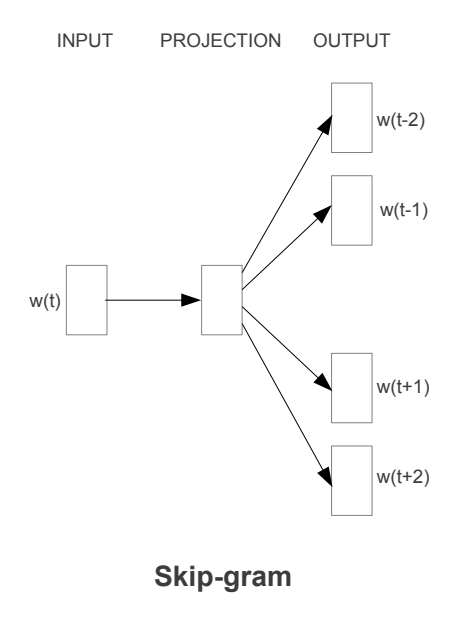

For the Skip-Gram objective, we initialize two embedding models: embedding and embedding_out.<br>
embedding is used to look up embeddings for the center words.<br>
embedding_out is used for the context words.

The weights of embedding are the final word embedding weights.

In [21]:
emsize = 300

embedding = nlp.model.train.SimpleEmbeddingModel(
    token_to_idx=vocab.token_to_idx,
    embedding_size=emsize,
    weight_initializer=mx.init.Uniform(scale=1 / emsize))

gluonnlp.model.train.SimpleEmbeddingModel <br>
https://gluon-nlp.mxnet.io/api/model.train.html#gluonnlp.model.train.SimpleEmbeddingModel

In [22]:
embedding_out = nlp.model.train.SimpleEmbeddingModel(
    token_to_idx=vocab.token_to_idx,
    embedding_size=emsize,
    weight_initializer=mx.init.Uniform(scale=1 / emsize))

In [25]:
embedding.initialize(ctx=context)
embedding_out.initialize(ctx=context)
embedding.hybridize(static_alloc=True)
embedding_out.hybridize(static_alloc=True)

In [26]:
dict(learning_rate=0.05)

{'learning_rate': 0.05}

In [28]:
params = list(embedding.collect_params().values()) + \
    list(embedding_out.collect_params().values())
trainer = mx.gluon.Trainer(params, 'adagrad', dict(learning_rate=0.05))

reference of Trainer
https://mxnet.incubator.apache.org/api/python/gluon/gluon.html#mxnet.gluon.Trainer

Before we start training, let’s examine the quality of our randomly initialized embeddings:

In [29]:
def norm_vecs_by_row(x):
    return x / (mx.nd.sum(x * x, axis=1) + 1e-10).sqrt().reshape((-1, 1))


def get_k_closest_tokens(vocab, embedding, k, word):
    word_vec = embedding(mx.nd.array([vocab.token_to_idx[word]],
                                     ctx=context)).reshape((-1, 1))
    vocab_vecs = norm_vecs_by_row(embedding.embedding.weight.data())
    dot_prod = mx.nd.dot(vocab_vecs, word_vec)
    indices = mx.nd.topk(
        dot_prod.reshape((len(vocab.idx_to_token), )),
        k=k + 1,
        ret_typ='indices')
    indices = [int(i.asscalar()) for i in indices]
    result = [vocab.idx_to_token[i] for i in indices[1:]]
    print('closest tokens to "%s": %s' % (word, ", ".join(result)))


example_token = "data"
get_k_closest_tokens(vocab, embedding, 10, example_token)

closest tokens to "data": toyota, zor, sahih, amoeboids, brokered, dore, wanderer, fabricate, geste, recumbent


## Training objective

### Native objective

To naively maximize the Skip-Gram objective, if we sample a center word we need to compute a prediction for every other word in the vocabulary if it occurs in the context of the center word or not. We can then backpropagate and update the parameters to make the prediction of the correct context words more likely and of all other words less likely.

However, this naive method is computationally very expensive as it requires computing a Softmax function over all words in the vocabulary. Instead, “Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. Efficient estimation of word representations in vector space. ICLR Workshop , 2013.” introduced Negative Sampling.

### Negative sampling

Negative Sampling means that instead of using a small number of correct (or positive) context and all other (negative) words to compute the loss and update the parameters we may choose a small, constant number of negative words at random. Negative words are choosen randomly based on their frequency in the training corpus. It is recommend to smoothen the frequency distribution by the factor 0.75.

We can use the UnigramCandidateSampler to sample tokens by some unigram weights.

In [30]:
num_negatives = 5
weights = mx.nd.array(idx_to_count)**0.75
negatives_sampler = nlp.data.UnigramCandidateSampler(weights)

### Center and context words

We can use EmbeddingCenterContextBatchify to transform a corpus into batches of center and context words.

In [31]:
batch_size = 2048
window_size = 5
batchify = nlp.data.batchify.EmbeddingCenterContextBatchify(batch_size=batch_size, window_size=window_size)
batches = batchify(subsampled_dataset)

To compute the loss with negative sampling we use SigmoidBinaryCrossEntropyLoss.

In [32]:
loss = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss()

In [33]:
def remove_accidental_hits(candidates, true_samples):
    """Compute a candidates_mask surpressing accidental hits.

    Accidental hits are candidates that occur in the same batch dimension of
    true_samples.

    """
    candidates_np = candidates.asnumpy()
    true_samples_np = true_samples.asnumpy()

    candidates_mask = np.ones(candidates.shape, dtype=np.bool_)
    for j in range(true_samples.shape[1]):
        candidates_mask &= ~(candidates_np == true_samples_np[:, j:j + 1])

    return candidates, mx.nd.array(candidates_mask, ctx=candidates.context)


def skipgram_batch(data):
    """Create a batch for Skipgram training objective."""
    centers, word_context, word_context_mask = data
    assert len(centers.shape) == 2
    negatives_shape = (len(word_context), 2 * window_size * num_negatives)
    negatives, negatives_mask = remove_accidental_hits(
        negatives_sampler(negatives_shape), word_context)
    context_negatives = mx.nd.concat(word_context, negatives, dim=1)
    masks = mx.nd.concat(word_context_mask, negatives_mask, dim=1)
    labels = mx.nd.concat(word_context_mask, mx.nd.zeros_like(negatives), dim=1)
    return (centers.as_in_context(context),
            context_negatives.as_in_context(context),
            masks.as_in_context(context),
            labels.as_in_context(context))

In [34]:
def train_embedding(num_epochs):
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        train_l_sum = 0
        num_samples = 0
        for i, data in enumerate(batches):
            (center, context_and_negative, mask,
             label) = skipgram_batch(data)
            with mx.autograd.record():
                emb_in = embedding(center)
                emb_out = embedding_out(context_and_negative)
                pred = mx.nd.batch_dot(emb_in, emb_out.swapaxes(1, 2))
                l = (loss(pred.reshape(label.shape), label, mask) *
                     mask.shape[1] / mask.sum(axis=1))
            l.backward()
            trainer.step(1)
            train_l_sum += l.sum()
            num_samples += center.shape[0]
            if i % 500 == 0:
                mx.nd.waitall()
                wps = num_samples / (time.time() - start_time)
                print('epoch %d, time %.2fs, iteration %d, throughput=%.2fK wps'
                      % (epoch, time.time() - start_time, i, wps / 1000))

        print('epoch %d, time %.2fs, train loss %.2f'
              % (epoch, time.time() - start_time,
                 train_l_sum.asscalar() / num_samples))
        get_k_closest_tokens(vocab, embedding, 10, example_token)
        print("")

In [35]:
train_embedding(num_epochs=5)

epoch 1, time 2.71s, iteration 0, throughput=0.76K wps
epoch 1, time 617.71s, iteration 500, throughput=1.66K wps
epoch 1, time 1241.25s, iteration 1000, throughput=1.65K wps
epoch 1, time 1848.49s, iteration 1500, throughput=1.66K wps
epoch 1, time 2453.87s, iteration 2000, throughput=1.67K wps
epoch 1, time 2796.56s, train loss 0.35
closest tokens to "data": identifiers, applications, interfaces, storing, implementations, encrypted, bandwidth, byte, identifier, programmable

epoch 2, time 1.53s, iteration 0, throughput=1.34K wps
epoch 2, time 615.96s, iteration 500, throughput=1.67K wps
epoch 2, time 1245.78s, iteration 1000, throughput=1.65K wps
epoch 2, time 1871.39s, iteration 1500, throughput=1.64K wps
epoch 2, time 2489.88s, iteration 2000, throughput=1.65K wps
epoch 2, time 2838.59s, train loss 0.31
closest tokens to "data": synchronization, metadata, dynamically, terabytes, identifiers, encoding, addressable, sequential, synchronous, bandwidth

epoch 3, time 1.51s, iteration 0

KeyboardInterrupt: 

## Evaluation of trained embedding

As we have only obtained word vectors for words that occured in the training corpus, we filter the evaluation dataset and exclude out of vocabulary words.

In [ ]:
words1, words2, scores = zip(*([vocab[d[0]], vocab[d[1]], d[2]]
    for d in wordsim353  if d[0] in vocab and d[1] in vocab))
words1 = mx.nd.array(words1, ctx=context)
words2 = mx.nd.array(words2, ctx=context)

We create a new TokenEmbedding object and set the embedding vectors for the words we care about for evaluation.

In [ ]:
token_embedding = nlp.embedding.TokenEmbedding(unknown_token=None, allow_extend=True)
token_embedding[vocab.idx_to_token] = embedding[vocab.idx_to_token]

evaluator = nlp.embedding.evaluation.WordEmbeddingSimilarity(
    idx_to_vec=token_embedding.idx_to_vec,
    similarity_function="CosineSimilarity")
evaluator.initialize(ctx=context)
evaluator.hybridize()

In [ ]:
pred_similarity = evaluator(words1, words2)
sr = stats.spearmanr(pred_similarity.asnumpy(), np.array(scores))
print('Spearman rank correlation on {} pairs of {} (total {}): {}'.format(
    len(words1), wordsim353.__class__.__name__, len(wordsim353), sr.correlation.round(3)))

# Unknown token handling and subword information

Sometimes we may run into a word for which the embedding does not include a word vector. While the vocab object is happy to replace it with a special index for unknown tokens.

In [ ]:
print('Is "hello" known? ', 'hello' in vocab)
print('Is "likelyunknown" known? ', 'likelyunknown' in vocab)

Some embedding models such as the FastText model support computing word vectors for unknown words by taking into account their subword units.
* Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. Efficient estimation of word representations in vector space. ICLR Workshop , 2013.